# Research Project - Uncertainty Quantification
- **Author** : Amine Rannen-Triki
- **Date**: 15/07/2025
- Imperial College London - Department of Mathematics
- MS Machine Learning and Data Science (MLDS)
- Notebook 03 - Phase 2 - Scalability and approximation (classification with ConfidNet, $L_{new}$ and SelectiveNet)



#0. Drive mounting and model download

Use this function and cells to download the pre-trained model from google Drive and are using this notebook on Collab.
Otherwise, make sure to upload the trained models in folder named `models`

In [3]:
from google.colab import drive
import shutil
from pathlib import Path

def mount_google_drive():
    """Mounts Google Drive to the Colab environment."""
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully.")
    except Exception as e:
        print(f"❌ An error occurred while mounting Google Drive: {e}")

def upload_models_to_drive(source_folder=Path("models"), destination_folder=Path("/content/drive/MyDrive/colab_model_backups")):
    """
    Uploads the models folder from Colab to a specified folder in Google Drive.

    Args:
        source_folder (Path): The path to the folder containing models in Colab.
        destination_folder (Path): The path to the desired destination folder in Google Drive.
    """
    destination_path = destination_folder / source_folder.name
    # Create the destination folder in Drive if it doesn't exist
    destination_folder.mkdir(exist_ok=True)

    try:
        # Use shutil.copytree to copy the folder and its contents
        # Use dirs_exist_ok=True to allow overwriting existing files/folders
        shutil.copytree(source_folder, destination_path, dirs_exist_ok=True)
        print(f"✅ Successfully copied '{source_folder}' to '{destination_path}'")
    except FileExistsError:
        # This exception is less likely with dirs_exist_ok=True, but good to keep as a fallback
        print(f"ℹ️ Destination folder '{destination_path}' already exists. Models were likely updated.")
    except Exception as e:
        print(f"❌ An error occurred while copying the models folder to Google Drive: {e}")

def download_models_from_drive(source_folder_drive=Path("/content/drive/MyDrive/colab_model_backups/models"), destination_folder_colab=Path(".")):
    """
    Downloads the models folder from Google Drive to a specified folder in Colab.

    Args:
        source_folder_drive (Path): The path to the models folder in Google Drive.
        destination_folder_colab (Path): The path to the desired destination folder in Colab.
    """
    destination_path = destination_folder_colab / source_folder_drive.name
    # Ensure the destination folder in Colab exists
    destination_folder_colab.mkdir(exist_ok=True)

    try:
        # Use shutil.copytree to copy the folder and its contents
        # Use dirs_exist_ok=True to allow overwriting existing files/folders
        shutil.copytree(source_folder_drive, destination_path, dirs_exist_ok=True)
        print(f"✅ Successfully copied '{source_folder_drive}' to '{destination_path}'")
    except FileExistsError:
         # This exception is less likely with dirs_exist_ok=True, but good to keep as a fallback
        print(f"ℹ️ Destination folder '{destination_path}' already exists. Models were likely updated.")
    except Exception as e:
        print(f"❌ An error occurred while copying the models folder from Google Drive: {e}")

mount_google_drive()

#uncomment to download saved models
#download_models_from_drive(source_folder_drive=Path("/content/drive/MyDrive/colab_model_backups/notebook_2_2")) #/content/drive/MyDrive/colab_model_backups/models
#download_models_from_drive(source_folder_drive=Path("/content/drive/MyDrive/colab_model_backups/models")) #
#upload_models_to_drive(source_folder=Path("models"),destination_folder=Path("/content/drive/MyDrive/colab_model_backups/notebook_2_2"))

Mounted at /content/drive
✅ Google Drive mounted successfully.


# 1. Preparation

## 1.1 Configuration and setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================================================================
# 1. Configuration & Setup
# ==========================================================================================

# Ensure the 'models' directory exists for saving weights
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_CLASSES = 10

EPOCHS_PREDICTOR = 10
LR_PREDICTOR = 0.01

EPOCHS_CONVICTION = 20
LR_CONVICTION = 0.001

EPOCHS_FINETUNE = 20
LR_FINETUNE = 1e-5

FINETUNE = 1e-5


# --- Hyperparameters ---
# 1. Define Experiment Configuration
config = {
    'device': DEVICE,
    'num_classes': NUM_CLASSES,
    'lr_finetune': LR_FINETUNE,
    'epochs_finetune': EPOCHS_FINETUNE,
    'batch_size': BATCH_SIZE,
}

## 1.2. Models definition

In [2]:
# ==========================================================================================
# 2. Model Definitions
# Define different architectures for :
#     - the predictor (f)
#     - conviction (w)
#     - JointModel (f+w)
# ==========================================================================================


class VGGStylePredictor(nn.Module):
    """A VGG-style classifier that also exposes its feature extractor and feature dimension."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Simplified for a flat feature vector

        # This is the dimension of the features right before the classifier head
        self.feature_dim = 512

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                ]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        """Full forward pass for prediction."""
        features = self.get_features(x)
        return self.classifier(features)

    def get_features(self, x):
        """Extracts features from the backbone."""
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

class SimpleConvPredictor(nn.Module):
    """A simpler convolutional predictor to demonstrate modularity."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Feature dimension for this model
        self.feature_dim = 64

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.get_features(x)
        return self.classifier(features)

    def get_features(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

class MLPConvictionNet(nn.Module):
    """A flexible MLP-based conviction network."""
    def __init__(self, input_dim):
        super().__init__()
        self.confid_layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output confidence between 0 and 1
        )

    def forward(self, x):
        return self.confid_layers(x)
# Create a combined model for fine-tuning that takes images as input
# This model contains both the predictor's feature extraction and the conviction network

class JointTrainingModel(nn.Module):
    """A model that wraps predictor and conviction net for joint training,
       outputting both predictor logits and conviction scores."""
    def __init__(self, predictor_model, conviction_network):
        super().__init__()
        self.predictor_model = predictor_model
        self.conviction_network = conviction_network

    def forward(self, x):
        # The joint model uses its own, internally updating feature extractor
        features = self.predictor_model.get_features(x)
        predictor_outputs = self.predictor_model.classifier(features)
        confidence = self.conviction_network(features)
        return predictor_outputs, confidence
class SelectiveNetHead(nn.Module):
    """
    Heads for SelectiveNet given a backbone with:
      - get_features(x) -> feature tensor (batch, feature_dim)
      - classifier: nn.Module producing logits_f
      - feature_dim: int
    """
    def __init__(self, backbone, num_classes=10, sel_hidden=128):
        super().__init__()
        self.backbone = backbone                      # e.g., VGGStylePredictor or SimpleConvPredictor
        feat_dim = backbone.feature_dim

        # f head already exists on backbone as `classifier` (produces logits_f)
        # h head: auxiliary classifier (same task as f)
        self.h = nn.Linear(feat_dim, num_classes)

        # g head: selection (logit); sigmoid applied in the loss for stability
        self.g = nn.Sequential(
            nn.Linear(feat_dim, sel_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(sel_hidden, 1)                  # -> g_logit (no sigmoid here)
        )

    def forward(self, x):
        z = self.backbone.get_features(x)             # (B, feature_dim)
        logits_f = self.backbone.classifier(z)        # (B, C)
        logits_h = self.h(z)                          # (B, C)
        g_logit  = self.g(z).squeeze(-1)              # (B,)
        return logits_f, logits_h, g_logit

    @torch.no_grad()
    def predict_with_reject(self, x, threshold=0.5):
        """
        Retourne (pred, accept_mask, g_prob). `pred` est la classe prédite si acceptée.
        """
        self.eval()
        logits_f, _, g_logit = self.forward(x)
        probs = torch.softmax(logits_f, dim=1)
        pred  = probs.argmax(dim=1)
        g_prob = torch.sigmoid(g_logit)
        accept = g_prob >= threshold
        return pred, accept, g_prob


## 1.3. Custom loss functions

In [3]:
# ==========================================================================================
# 3. Custom Loss Functions
# ==========================================================================================

class WeightedSumLoss(nn.Module):
    """Custom loss function for fine-tuning the combined model."""
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss(reduction='none') # Use reduction='none' to get element-wise loss

    def forward(self, predictions, targets, confidence_weights):
        # predictions are the confidence scores from the conviction network
        # targets are the TCP values from the predictor

        # Calculate the squared error for each prediction
        squared_errors = self.mse(predictions, targets)

        # Calculate the confidence weights: higher weight for lower confidence
        # Add a small epsilon to avoid division by zero if confidence is exactly 0
        # Calculate the weighted squared error
        weighted_squared_errors = squared_errors * confidence_weights

        # Calculate the weighted mean squared error, adding a small epsilon for stability
        weighted_mse = torch.sum(weighted_squared_errors) / (torch.sum(confidence_weights) + 1e-8)

        # The loss is the weighted MSE
        loss = weighted_mse

        return loss

class L_new_Loss(nn.Module):
    """
    Implementation of the L_new loss for joint training using EMA algorithm.
    L_new = sum(conviction * predictor_loss) / sum(conviction)
    """
    def __init__(self, initial_denominator=1.0, alpha=0.99):
        super().__init__()
        # Use CrossEntropyLoss with no reduction to get per-sample loss
        self.predictor_loss_fn = nn.CrossEntropyLoss(reduction='none')
        # Register the running denominator as a buffer to track it
        self.register_buffer('running_denominator', torch.tensor(initial_denominator, dtype=torch.float32))
        self.alpha = alpha

    def forward(self, predictor_outputs, labels, conviction_scores):
        # 1. Calculate the predictor's per-sample loss
        per_sample_predictor_loss = self.predictor_loss_fn(predictor_outputs, labels)

        # 2. Calculate the numerator: conviction-weighted predictor loss
        numerator = torch.sum(conviction_scores.squeeze() * per_sample_predictor_loss)

        # 3. Update the running average of the denominator (approximating the global sum)
        # We use a detached version of the batch sum to prevent this update from affecting gradients
        current_batch_denominator_sum = torch.sum(conviction_scores).detach()
        self.running_denominator = self.alpha * self.running_denominator + (1 - self.alpha) * current_batch_denominator_sum

        # 4. Calculate the final loss
        # We use the updated running denominator. Use .detach() on the denominator
        # during the division to ensure the gradient only flows through the numerator.
        final_loss = numerator / self.running_denominator.detach()

        return final_loss

class SelectiveNetLoss(nn.Module):
    """
    Loss SelectiveNet (classification):
      L = alpha * [ r_hat + lam * ReLU(target_cov - phi_hat)^2 ] + (1 - alpha) * CE_h
    où:
      - r_hat   = (sum_i CE_f(i) * g_i) / (sum_i g_i)      (risque sélectif)
      - phi_hat = mean_i g_i                                (couverture batch)
      - g_i     = sigmoid(g_logit_i) ∈ (0,1)
    Entrées attendues du forward:
      logits_f: (B, C)  - tête de prédiction f
      logits_h: (B, C)  - tête auxiliaire h
      g_logit : (B,)    - logit de sélection g (sigmoid appliqué ici dans la loss)
      labels  : (B,)    - entiers [0..C-1]
    """
    def __init__(self, target_coverage: float = 0.7, lam: float = 32.0, alpha: float = 0.5, eps: float = 1e-6):
        super().__init__()
        self.target_coverage = float(target_coverage)
        self.lam = float(lam)
        self.alpha = float(alpha)
        self.eps = float(eps)
        self.ce = nn.CrossEntropyLoss(reduction='none')   # pour CE_f
        self.ce_mean = nn.CrossEntropyLoss(reduction='mean')  # pour CE_h

    def forward(self, logits_f, logits_h, g_logit, labels):
        # CE par échantillon pour la tête f (sans réduction)
        ce_f = self.ce(logits_f, labels)                         # (B,)
        # CE moyenne pour la tête auxiliaire h
        ce_h = self.ce_mean(logits_h, labels)                    # scalaire

        # Sélection g dans (0,1) avec clamp pour stabilité
        g = torch.sigmoid(g_logit).clamp(self.eps, 1.0 - self.eps)  # (B,)

        # Risque sélectif: moyenne pondérée par g
        denom = g.sum() + self.eps
        r_hat = (ce_f * g).sum() / denom

        # Couverture batch
        phi_hat = g.mean()

        # Pénalité de couverture (barrier/quadratic)
        cov_penalty = F.relu(self.target_coverage - phi_hat) ** 2

        # Terme principal f,g
        L_fg = r_hat + self.lam * cov_penalty

        # Loss totale
        loss = self.alpha * L_fg + (1.0 - self.alpha) * ce_h

        # On renvoie aussi quelques métriques pratiques
        with torch.no_grad():
            metrics = dict(
                selective_risk=r_hat.detach(),
                batch_coverage=phi_hat.detach(),
                cov_penalty=cov_penalty.detach(),
                ce_h=ce_h.detach()
            )
        return loss, metrics


## 1.4. Data, Training, and Evaluation Utilities

In [4]:
# ==========================================================================================
# 4. Data, Training, and Evaluation Utilities
# ==========================================================================================

# ==========================================================================================
# A utility function to prepare the CIFAR-10 dataset.
# ==========================================================================================

def get_cifar10_loaders(batch_size=128):
    """Returns train and test DataLoaders for CIFAR-10."""
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

# A utility function to prepare the CIFAR-10 dataset for the SelectiveNet method.
# ==========================================================================================

def get_cifar10_loaders_with_val(batch_size=128, val_size=5000, num_workers=2):
    import torchvision
    from torchvision import transforms

    tf_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    tf_eval = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tf_train)
    testset    = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tf_eval)

    # Split train -> train/val
    train_size = len(full_train) - val_size
    trainset, valset = torch.utils.data.random_split(
        full_train, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = torch.utils.data.DataLoader(valset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader



# ==========================================================================================
# Training & Preparation Utilities
# Reusable functions for each stage of the process.
# ==========================================================================================

def train_predictor(model, train_loader, epochs, lr, device, model_save_path):
    """Train the base predictor model (Stage 1)."""
    print(f"--- Stage 1: Training Predictor ({model.__class__.__name__}) ---")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.3f}")
                running_loss = 0.0

    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Predictor model saved to {model_save_path}\n")

def prepare_conviction_data(predictor, data_loader, device):
    """
    Extracts features and calculates True Class Probability (TCP) targets
    to create a new dataset for training the conviction network.
    """
    print("--- Preparing data for Conviction Network ---")
    predictor.to(device)
    predictor.eval() # Freeze the predictor

    all_features = []
    all_tcp_targets = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Extract features from the frozen predictor
            features = predictor.get_features(inputs)

            # Get full output to calculate TCP
            outputs = predictor.classifier(features)
            softmax_probs = F.softmax(outputs, dim=1)
            tcp_targets = softmax_probs.gather(1, labels.unsqueeze(1)).squeeze()

            all_features.append(features.cpu())
            all_tcp_targets.append(tcp_targets.cpu())

    dataset = torch.utils.data.TensorDataset(torch.cat(all_features), torch.cat(all_tcp_targets))
    loader = torch.utils.data.DataLoader(dataset, batch_size=data_loader.batch_size, shuffle=True)
    print("✅ Conviction data prepared.\n")
    return loader

def train_conviction_network(model, train_loader, epochs, lr, device, model_save_path, stage_name="", loss_fn=nn.MSELoss()):
    """Train a model (conviction net or combined model) using MSE loss against TCP targets."""
    print(f"--- {stage_name} ---")
    model.to(device)
    criterion = loss_fn
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            predictions = model(features).squeeze()

            # Check if the loss function is WeightedSumLoss
            #if isinstance(criterion, WeightedSumLoss):
            #    loss = criterion(predictions, targets, predictions)
            #else:
            loss = criterion(predictions, targets)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}")
                running_loss = 0.0

    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Model saved to {model_save_path}\n")


def build_selectivenet(backbone_cls, num_classes=10, sel_hidden=128):
    backbone = backbone_cls(num_classes=num_classes)
    model = SelectiveNetHead(backbone, num_classes=num_classes, sel_hidden=sel_hidden)
    return model

@torch.no_grad()
def calibrate_selective_threshold(model, val_loader, device, target_coverage=0.7):
    model.to(device).eval()
    all_g = []
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        _, _, g_logit = model(inputs)
        g = torch.sigmoid(g_logit)
        all_g.append(g.detach().cpu())
    g_all = torch.cat(all_g).numpy()
    # accept if g >= tau → pick tau at (1 - target_coverage) quantile
    tau = float(np.quantile(g_all, 1.0 - target_coverage))
    return tau



## 1.5. Experiment Runner

In [5]:
# ==========================================================================================
# 5. Experiment Runner
# ==========================================================================================


def run_existing_experiment(loss_name, config, base_paths, loaders):
    """
    Runs the full fine-tuning and evaluation experiment for a given loss function.
    """
    print(f"\n{'='*30}\n💥 STARTING EXPERIMENT: {loss_name} 💥\n{'='*30}")

    # --- Unpack config, paths, and loaders ---
    DEVICE = config['device']
    NUM_CLASSES = config['num_classes']
    LR_FINETUNE = config['lr_finetune']
    EPOCHS_FINETUNE = config['epochs_finetune']

    predictor_path = base_paths['predictor']
    conviction_path = base_paths['conviction']
    # Save the final model with a unique name based on the loss used
    finetuned_path = Path(f"models/finetuned_model_{loss_name}.pth")

    train_loader, test_loader = loaders

    # --- Model Initialization ---
    # Always start with the same pre-trained predictor and conviction network for a fair comparison
    predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))

    conviction_net = MLPConvictionNet(input_dim=predictor.feature_dim)
    conviction_net.load_state_dict(torch.load(conviction_path, map_location=DEVICE))

    # Use the JointTrainingModel for both experiments for consistency
    #         predictor_outputs = self.predictor_model.classifier(features)
    joint_model = JointTrainingModel(predictor, conviction_net).to(DEVICE)
    optimizer = optim.Adam(joint_model.parameters(), lr=LR_FINETUNE)

    # Create a SEPARATE, FROZEN predictor just for generating targets
    #target_predictor = VGGStylePredictor(num_classes=NUM_CLASSES).to(DEVICE)
    #target_predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))
    #target_predictor.eval().to(DEVICE) # Set to evaluation mode once. It will not be trained.


    # --- Select Loss Function & Prepare for Loop ---
    if loss_name == 'MSE':
        criterion = nn.MSELoss()
    elif loss_name == 'L_new':
        criterion = L_new_Loss().to(DEVICE)
    else:
        raise ValueError(f"Unsupported loss function: {loss_name}")

    print(f"--- Stage 3 (Fine-Tuning): Using {loss_name} loss ---")
    # --- Fine-Tuning Loop ---
    for epoch in range(EPOCHS_FINETUNE):
        joint_model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            predictor_outputs, conviction_scores = joint_model(inputs)

            # Calculate loss based on the chosen method
            if loss_name == 'MSE':
                with torch.no_grad():
                  # For the MSE case, we need a frozen, original predictor to generate TCP targets
                  #target_predictor = VGGStylePredictor(num_classes=NUM_CLASSES).to(DEVICE)
                  #target_predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))
                  #target_predictor.eval().to(DEVICE)
                  #original_outputs = target_predictor(inputs)
                  original_outputs = predictor(inputs)
                  softmax_outputs = F.softmax(original_outputs, dim=1)
                  tcp_targets = softmax_outputs.gather(1, labels.unsqueeze(1)).squeeze()
                predicted_confidence = conviction_scores.squeeze()
                loss = criterion(predicted_confidence, tcp_targets)

                #loss = criterion(conviction_scores.squeeze(), tcp_targets)

            else:  # L_new case
                features = predictor.get_features(inputs)
                predictor_outputs = predictor.classifier(features)
                conviction_scores = conviction_net(features)
                # Get predicted confidence from the fine-tuned model
                # This automatically uses the potentially updated feature extractor within combined_model
                #predicted_confidence = fine_tune_combined_model(inputs).squeeze()
                # Calculate loss
                #loss = fine_tune_criterion(predicted_confidence, tcp_targets)
                #loss = fine_tune_criterion(predicted_confidence, tcp_targets, predicted_confidence) #MSE Case
                #loss = fine_tune_criterion(predictor_outputs, labels, conviction_scores) #Lnew case

                loss = criterion(predictor_outputs, labels, conviction_scores)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch [{epoch + 1}/{EPOCHS_FINETUNE}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

    # --- Save and Evaluate ---
    torch.save(joint_model.state_dict(), finetuned_path)
    print(f"✅ Fine-tuned model ({loss_name}) saved to {finetuned_path}\n")

    # results, confidences, correctness = evaluate_joint_model(
    #     joint_model=joint_model,
    #     test_loader=test_loader,
    #     device=DEVICE,
    #     model_name=loss_name
    # )
    # Load the original predictor for calculating accuracy
    #final_predictor = SimpleConvPredictor(num_classes=NUM_CLASSES) # Use the same class as trained
    final_predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    final_predictor.load_state_dict(torch.load(predictor_path))
    final_predictor.eval().to(DEVICE) # Ensure predictor is on the correct device for evaluation

    # Load the fine-tuned conviction network directly
    final_conviction_net = MLPConvictionNet(input_dim=final_predictor.feature_dim)
    # Load the state dict of the conviction network from the saved combined model state dict
    combined_model_state_dict = torch.load(finetuned_path)
    # Extract the state dict for the conviction network part
    conviction_net_state_dict = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict.items() if 'conviction_network.' in k}
    final_conviction_net.load_state_dict(conviction_net_state_dict)
    final_conviction_net.eval().to(DEVICE) # Ensure conviction net is on the correct device


    results, confidences, correctness = evaluate_conviction_system(
        predictor=final_predictor,
        conviction_model=final_conviction_net, # Pass the fine-tuned conviction net
        test_loader=test_loader,
        device=DEVICE
    )


    return results, confidences, correctness
@torch.no_grad()
def evaluate_selective(model, loader, device, threshold=0.5):
    model.to(device).eval()
    n_total = 0
    n_accept = 0
    n_correct_accept = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits_f, _, g_logit = model(inputs)
        probs = F.softmax(logits_f, dim=1)
        pred = probs.argmax(dim=1)
        g = torch.sigmoid(g_logit)

        accept = (g >= threshold)
        n_total += inputs.size(0)
        n_accept += accept.sum().item()
        n_correct_accept += ((pred == labels) & accept).sum().item()

    coverage = n_accept / n_total
    acc_on_accepted = (n_correct_accept / n_accept) if n_accept > 0 else 0.0
    return {"coverage": coverage, "acc_on_accepted": acc_on_accepted}


def run_experiment(loss_name, config, base_paths, loaders, method="joint_or_confidentnet"):
    """
    method can be: "joint_or_confidentnet" training (based on 'run_existing_experiment' ) or "selectivenet".
    When method="selectivenet", we ignore JointTrainingModel and train SelectiveNetHead instead.
    """
    print(f"\n{'='*30}\n💥 STARTING EXPERIMENT: {loss_name} (method={method}) 💥\n{'='*30}")

    DEVICE = config['device']
    NUM_CLASSES = config['num_classes']
    LR_FINETUNE = config['lr_finetune']
    EPOCHS_FINETUNE = config['epochs_finetune']
    TARGET_COV = config.get('target_coverage', 0.7)
    LAM        = config.get('lambda_cov', 32.0)
    ALPHA      = config.get('alpha_sel', 0.5)

    predictor_path = base_paths.get('predictor')
    conviction_path = base_paths.get('conviction')

    # --- Loaders ---
    # if loaders has val (tuple of 3), unpack it; else assume 2.
    if len(loaders) == 3:
        train_loader, val_loader, test_loader = loaders
    else:
        train_loader, test_loader = loaders
        val_loader = None

    if method.lower() != "selectivenet":
        return run_existing_experiment(loss_name, config, base_paths, loaders)

    # ===== SelectiveNet path =====
    # Build SelectiveNet model on top of the same VGG backbone
    selective_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES).to(DEVICE)

    # Initialize the backbone with our pre-trained predictor weights (if exist):
    if predictor_path is not None:
        # load state dict into backbone only (classifier + features)
        pretrained = VGGStylePredictor(num_classes=NUM_CLASSES)
        pretrained.load_state_dict(torch.load(predictor_path, map_location=DEVICE))
        # copy weights to selective_model.backbone
        selective_model.backbone.load_state_dict(pretrained.state_dict(), strict=True)
        print("✅ Initialized SelectiveNet backbone from pre-trained predictor.")

    # Loss & Optimisation definition
    criterion_sel = SelectiveNetLoss(target_coverage=TARGET_COV, lam=LAM, alpha=ALPHA).to(DEVICE)
    optimizer = optim.Adam(selective_model.parameters(), lr=LR_FINETUNE)

    print(f"--- Stage 3 (SelectiveNet Fine-Tuning): target_cov={TARGET_COV} lam={LAM} alpha={ALPHA} ---")
    for epoch in range(EPOCHS_FINETUNE):
        selective_model.train()
        running = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            logits_f, logits_h, g_logit = selective_model(inputs)
            loss, metrics = criterion_sel(logits_f, logits_h, g_logit, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running.append(loss.item())
            if i % 100 == 99:
                print(f"Epoch [{epoch+1}/{EPOCHS_FINETUNE}] Step [{i+1}/{len(train_loader)}] "
                      f"Loss={np.mean(running):.4f} Risk={metrics['selective_risk']:.4f} Cov={metrics['batch_coverage']:.3f}")
                running = []

    # Calibrate threshold on val loader (required)
    if val_loader is None:
        raise ValueError("SelectiveNet requires a validation loader to calibrate the acceptance threshold.")
    tau = calibrate_selective_threshold(selective_model, val_loader, device=DEVICE, target_coverage=TARGET_COV)
    print(f"✅ Calibrated threshold τ = {tau:.4f}")

    # Evaluate on test
    test_metrics = evaluate_selective(selective_model, test_loader, device=DEVICE, threshold=tau)
    print(f"Test @ τ: coverage={test_metrics['coverage']:.3f}, acc_on_accepted={test_metrics['acc_on_accepted']:.3f}")

    # Save model + threshold
    finetuned_path = Path(f"models/finetuned_selectivenet_{loss_name}.pth")
    torch.save({"state_dict": selective_model.state_dict(), "tau": tau}, finetuned_path)
    print(f"✅ SelectiveNet saved to {finetuned_path}\n")

    return test_metrics, None, None  # keep signature consistent with your return


## 1.6 Evaluation and visualisation

In [6]:


# ==========================================================================================
## 4. Evaluation Utilities
# Functions to compute metrics and visualize results.
# ==========================================================================================

def evaluate_conviction_system(predictor, conviction_model, test_loader, device):
    """Evaluates the conviction system on the test set."""
    print("--- Evaluating Conviction System ---")
    predictor.to(device).eval()
    conviction_model.to(device).eval()

    is_correct_list = []
    predicted_confidence_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get base model predictions to check correctness
            features = predictor.get_features(inputs)
            outputs = predictor.classifier(features)
            _, predicted_classes = torch.max(outputs.data, 1)
            is_correct_list.extend((predicted_classes == labels).cpu().numpy())

            # Get conviction network's confidence prediction
            confidence = conviction_model(features).squeeze()
            predicted_confidence_list.extend(confidence.cpu().numpy())

    is_correct_list = np.array(is_correct_list)
    predicted_confidence_list = np.array(predicted_confidence_list)

    # --- Calculate Metrics ---
    # Labels for failure prediction: 1 for incorrect, 0 for correct
    failure_labels = 1 - is_correct_list
    # Scores for failure prediction: lower confidence = higher chance of failure
    failure_scores = 1 - predicted_confidence_list

    results = {
        "accuracy": np.mean(is_correct_list) * 100,
        "auroc": roc_auc_score(failure_labels, failure_scores),
        "auprc": average_precision_score(failure_labels, failure_scores),
        "mean_conf_correct": np.mean(predicted_confidence_list[is_correct_list == 1]),
        "mean_conf_incorrect": np.mean(predicted_confidence_list[is_correct_list == 0]),
    }

    print(f"Base Predictor Accuracy: {results['accuracy']:.2f}%")
    print(f"AUROC for Failure Prediction: {results['auroc']:.4f}")
    print(f"AUPRC for Failure Prediction: {results['auprc']:.4f}")
    print(f"Mean Confidence (Correct): {results['mean_conf_correct']:.4f}")
    print(f"Mean Confidence (Incorrect): {results['mean_conf_incorrect']:.4f}")

    return results, predicted_confidence_list, is_correct_list

def plot_confidence_distribution(confidences, correctness, title="Confidence Distribution"):
    """Plots the confidence distributions for correct vs. incorrect predictions."""

    predicted_confidence_list = np.array(confidences)
    is_correct_list = np.array(correctness)

    # Separate confidence scores for correct and incorrect predictions
    predicted_confidence_correct = predicted_confidence_list[is_correct_list == 1]
    predicted_confidence_incorrect = predicted_confidence_list[is_correct_list == 0]

    mean_conf_correct = np.mean(predicted_confidence_correct)
    median_conf_correct = np.median(predicted_confidence_correct)
    std_conf_correct = np.std(predicted_confidence_correct)

    mean_conf_incorrect = np.mean(predicted_confidence_incorrect)
    median_conf_incorrect = np.median(predicted_confidence_incorrect)
    std_conf_incorrect = np.std(predicted_confidence_incorrect)
    # Set plot style
    sns.set_style("whitegrid")

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot histograms for correct and incorrect predictions
    sns.histplot(predicted_confidence_correct, color='skyblue', label='Correct Predictions', kde=True, stat='density', common_norm=False)
    sns.histplot(predicted_confidence_incorrect, color='salmon', label='Incorrect Predictions', kde=True, stat='density', common_norm=False)

    # Add labels and title
    plt.xlabel("Predicted Confidence")
    plt.ylabel("Density")
    plt.title("Distribution of Predicted Confidence for Correct and Incorrect Predictions")
    plt.legend()

    # Optionally, add vertical lines for mean/median
    plt.axvline(mean_conf_correct, color='skyblue', linestyle='dashed', linewidth=1, label=f'Mean Correct ({mean_conf_correct:.2f})')
    plt.axvline(mean_conf_incorrect, color='salmon', linestyle='dashed', linewidth=1, label=f'Mean Incorrect ({mean_conf_incorrect:.2f})')
    plt.legend()

    # Display the plot
    plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.histplot(confidences[correctness == 1], color='skyblue', label='Correct Predictions', kde=True, stat='density', common_norm=False)
    # sns.histplot(confidences[correctness == 0], color='salmon', label='Incorrect Predictions', kde=True, stat='density', common_norm=False)
    # plt.title(title)
    # plt.xlabel("Predicted Confidence")
    # plt.ylabel("Density")
    # plt.legend()
    # plt.show()


@torch.no_grad()
def risk_coverage_curve(model, loader, device, num_points=20):
    # collect all g and correctness on a held-out set
    model.to(device).eval()
    all_g, all_correct = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits_f, _, g_logit = model(x)
        pred = logits_f.argmax(dim=1)
        correct = (pred == y).detach().cpu().numpy().astype(np.float32)
        g = torch.sigmoid(g_logit).detach().cpu().numpy()
        all_g.append(g); all_correct.append(correct)
    g = np.concatenate(all_g); correct = np.concatenate(all_correct)

    # sweep thresholds
    taus = np.quantile(g, np.linspace(0, 1, num_points))
    points = []
    for tau in taus:
        accept = g >= tau
        cov = accept.mean()
        if accept.sum() > 0:
            risk = 1.0 - (correct[accept].mean())  # error on accepted
        else:
            risk = np.nan
        points.append((cov, risk))
    return np.array(points)  # shape (num_points, 2)

def evaluate_predictor_accuracy(predictor_model, data_loader, device):
    """Evaluates the accuracy of a predictor model."""
    predictor_model.to(device).eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = predictor_model(inputs)
            _, predicted_classes = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()

    accuracy = (correct_predictions / total_samples) * 100
    return accuracy


# 2. Execution

In [7]:
# ============================
# EXECUTION: run 3 methods & compare
# ============================
from pathlib import Path
import numpy as np
import pandas as pd
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
NUM_CLASSES = config['num_classes']
DEVICE      = config['device']
BATCH_SIZE  = config.get('batch_size', 128)
EPOCHS_PREDICTOR  = config.get('epochs_predictor', 20)
LR_PREDICTOR      = config.get('lr_predictor', 0.1)
EPOCHS_CONVICTION = config.get('epochs_conviction', 10)
LR_CONVICTION     = config.get('lr_conviction', 1e-3)
EPOCHS_FINETUNE   = config.get('epochs_finetune', 10)
LR_FINETUNE       = config.get('lr_finetune', 3e-4)

TARGET_COV   = config.get('target_coverage', 0.7)   # for SelectiveNet
LAMBDA_COV   = config.get('lambda_cov', 32.0)
ALPHA_SEL    = config.get('alpha_sel', 0.5)

MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True, parents=True)

# --- MODEL SELECTION ---
predictor = VGGStylePredictor(num_classes=NUM_CLASSES)   # or SimpleConvPredictor
conviction_net = MLPConvictionNet(input_dim=predictor.feature_dim)

# --- PATHS ---
predictor_path  = MODELS_DIR / f"{predictor.__class__.__name__}.pth"
conviction_path = MODELS_DIR / f"{conviction_net.__class__.__name__}.pth"
finetuned_mse_path = MODELS_DIR / "finetuned_model_MSE.pth"
finetuned_lnew_path = MODELS_DIR / "finetuned_model_L_new.pth"
finetuned_selective_path = MODELS_DIR / "finetuned_selectivenet_selective_objective.pth"


# --- DATA ---
# keep your original for existing methods
train_loader, test_loader = get_cifar10_loaders(batch_size=BATCH_SIZE)
# add a val loader for SelectiveNet:
try:
    train_loader_val, val_loader, test_loader_val = get_cifar10_loaders_with_val(batch_size=BATCH_SIZE)
except NameError:
    print("Define get_cifar10_loaders_with_val(...) as shown earlier.")
    raise

# ============================
# STAGE 1: Train predictor (if needed)
# ============================
if not predictor_path.exists():
    train_predictor(model=predictor,
                    train_loader=train_loader,
                    epochs=EPOCHS_PREDICTOR,
                    lr=LR_PREDICTOR,
                    device=DEVICE,
                    model_save_path=predictor_path)
else:
    print(f"--- Stage 1: Found existing predictor at {predictor_path}, skipping training. ---")
    # Load the model even if skipping training, as it's needed for Stage 2
    predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))


# ============================
# STAGE 2: Train conviction net (if needed)
# ============================
if not conviction_path.exists():
    # Ensure predictor is on the correct device for feature extraction in prepare_conviction_data
    predictor.to(DEVICE)
    conviction_train_loader = prepare_conviction_data(predictor, train_loader, DEVICE)
    train_conviction_network(model=conviction_net,
                             train_loader=conviction_train_loader,
                             epochs=EPOCHS_CONVICTION,
                             lr=LR_CONVICTION,
                             device=DEVICE,
                             model_save_path=conviction_path,
                             stage_name="Stage 2: Training Conviction Network (Frozen Predictor)")
else:
    print(f"--- Stage 2: Found existing conviction net at {conviction_path}, skipping training. ---")
    # Load the model even if skipping training
    conviction_net.load_state_dict(torch.load(conviction_path, map_location=DEVICE))


# ============================
# BASE MODELS CHECK (Ensure base models are loaded if training was skipped)
# ============================
# Re-load if needed (e.g., if a new runtime but models were copied from Drive)
if not predictor.state_dict(): # Check if state_dict is empty
     predictor.load_state_dict(torch.load(predictor_path, map_location=DEVICE))
     print("Loaded predictor for subsequent stages.")
if not conviction_net.state_dict(): # Check if state_dict is empty
    conviction_net.load_state_dict(torch.load(conviction_path, map_location=DEVICE))
    print("Loaded conviction net for subsequent stages.")


base_predictor_name = VGGStylePredictor(num_classes=NUM_CLASSES).__class__.__name__
base_conviction_name = MLPConvictionNet(input_dim=VGGStylePredictor().feature_dim).__class__.__name__
base_paths = {
    'predictor': Path(f"models/{base_predictor_name}.pth"),
    'conviction': Path(f"models/{base_conviction_name}.pth")
}
if not base_paths['predictor'].exists() or not base_paths['conviction'].exists():
    raise RuntimeError("‼️ Base models not found. Train Stage 1 & 2 first or copy them from backup.")

# ============================
# RUN 1) ConfidentNet (MSE) - Fine-tuning
# ============================
if not finetuned_mse_path.exists():
    mse_results, mse_confidences, mse_correctness = run_existing_experiment(
        'MSE', config, base_paths, (train_loader, test_loader)
    )
else:
    print(f"--- Fine-tuning MSE: Found existing model at {finetuned_mse_path}, skipping training. ---")
    # Load results/confidences if skipping training (this part might need adjustment
    # depending on whether you saved results or need to re-run evaluation)
    # For now, we assume evaluation is always run after checking model existence
    # or that you load results from a separate file if you saved them.
    # Let's re-run evaluation if the model exists.
    # Load the fine-tuned Joint model (MSE)
    joint_model_mse = JointTrainingModel(
        VGGStylePredictor(num_classes=NUM_CLASSES),
        MLPConvictionNet(input_dim=VGGStylePredictor().feature_dim)
    ).to(DEVICE)
    joint_model_mse.load_state_dict(torch.load(finetuned_mse_path, map_location=DEVICE))

    # Evaluate using the loaded fine-tuned model
    # Need to extract predictor and conviction net from joint model for evaluate_conviction_system
    predictor_mse = joint_model_mse.predictor_model
    conviction_net_mse = joint_model_mse.conviction_network

    mse_results, mse_confidences, mse_correctness = evaluate_conviction_system(
        predictor=predictor_mse,
        conviction_model=conviction_net_mse,
        test_loader=test_loader,
        device=DEVICE
    )



# ============================
# RUN 2) Joint (L_new) - Fine-tuning
# ============================
if not finetuned_lnew_path.exists():
    lnew_results, lnew_confidences, lnew_correctness = run_existing_experiment(
        'L_new', config, base_paths, (train_loader, test_loader)
    )
else:
    print(f"--- Fine-tuning L_new: Found existing model at {finetuned_lnew_path}, skipping training. ---")
    # Re-run evaluation if the model exists
    joint_model_lnew = JointTrainingModel(
        VGGStylePredictor(num_classes=NUM_CLASSES),
        MLPConvictionNet(input_dim=VGGStylePredictor().feature_dim)
    ).to(DEVICE)
    joint_model_lnew.load_state_dict(torch.load(finetuned_lnew_path, map_location=DEVICE))

    predictor_lnew = joint_model_lnew.predictor_model
    conviction_net_lnew = joint_model_lnew.conviction_network

    lnew_results, lnew_confidences, lnew_correctness = evaluate_conviction_system(
        predictor=predictor_lnew,
        conviction_model=conviction_net_lnew,
        test_loader=test_loader,
        device=DEVICE
    )

# ============================
# RUN 3) SelectiveNet - Fine-tuning
# ============================
if not finetuned_selective_path.exists():
    sel_metrics, _, _ = run_experiment(
        loss_name="selective_objective",
        config={
            **config,
            "target_coverage": TARGET_COV,
            "lambda_cov": LAMBDA_COV,
            "alpha_sel": ALPHA_SEL
        },
        base_paths={"predictor": str(predictor_path)},   # initialize backbone from predictor
        loaders=(train_loader_val, val_loader, test_loader_val),
        method="selectivenet"
    )
    # sel_metrics keys: {"coverage": ..., "acc_on_accepted": ...}
else:
    print(f"--- Fine-tuning SelectiveNet: Found existing model at {finetuned_selective_path}, skipping training. ---")
    # Re-run evaluation if the model exists
    ckpt_sel = torch.load(finetuned_selective_path, map_location=DEVICE)
    sel_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
    sel_model.load_state_dict(ckpt_sel["state_dict"]); sel_model.eval().to(DEVICE)
    tau = ckpt_sel["tau"] # Load the saved threshold

    sel_metrics = evaluate_selective(sel_model, test_loader_val, device=DEVICE, threshold=tau)



100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


--- Stage 1: Training Predictor (VGGStylePredictor) ---
Epoch [1/20], Batch [100/391], Loss: 2.350
Epoch [1/20], Batch [200/391], Loss: 2.126
Epoch [1/20], Batch [300/391], Loss: 1.990
Epoch [2/20], Batch [100/391], Loss: 1.889
Epoch [2/20], Batch [200/391], Loss: 1.800
Epoch [2/20], Batch [300/391], Loss: 1.720
Epoch [3/20], Batch [100/391], Loss: 1.591
Epoch [3/20], Batch [200/391], Loss: 1.522
Epoch [3/20], Batch [300/391], Loss: 1.465
Epoch [4/20], Batch [100/391], Loss: 1.313
Epoch [4/20], Batch [200/391], Loss: 1.240
Epoch [4/20], Batch [300/391], Loss: 1.206
Epoch [5/20], Batch [100/391], Loss: 1.091
Epoch [5/20], Batch [200/391], Loss: 1.067
Epoch [5/20], Batch [300/391], Loss: 1.068
Epoch [6/20], Batch [100/391], Loss: 0.957
Epoch [6/20], Batch [200/391], Loss: 0.973
Epoch [6/20], Batch [300/391], Loss: 0.945
Epoch [7/20], Batch [100/391], Loss: 0.896
Epoch [7/20], Batch [200/391], Loss: 0.874
Epoch [7/20], Batch [300/391], Loss: 0.863
Epoch [8/20], Batch [100/391], Loss: 0.82

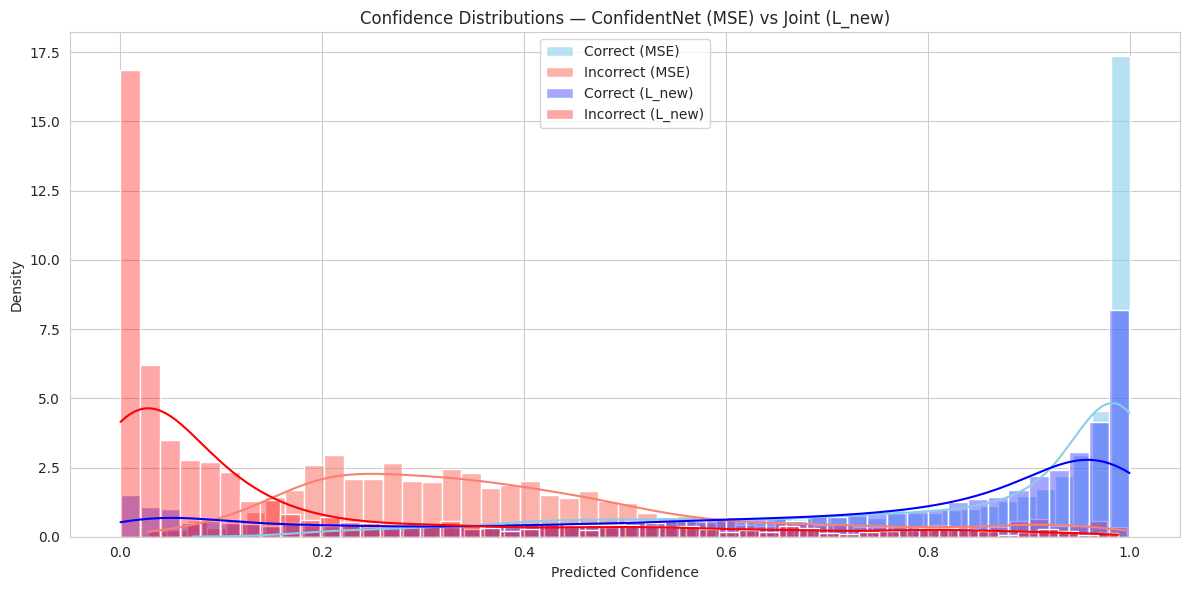


--- 📊 Updated Final Metrics Comparison (mixed) ---


,accuracy,auroc,auprc,coverage,acc_on_accepted
method,,,,,
ConfidentNet (MSE),75.47,0.893211,0.733188,NaN,NaN
Joint (L_new) After Finetuning,85.27,0.891772,0.712995,NaN,NaN
SelectiveNet (No Rejection),89.57,0.911056,0.533190,100.00,89.570000
SelectiveNet (with Rejection),NaN,NaN,NaN,69.67,98.478542


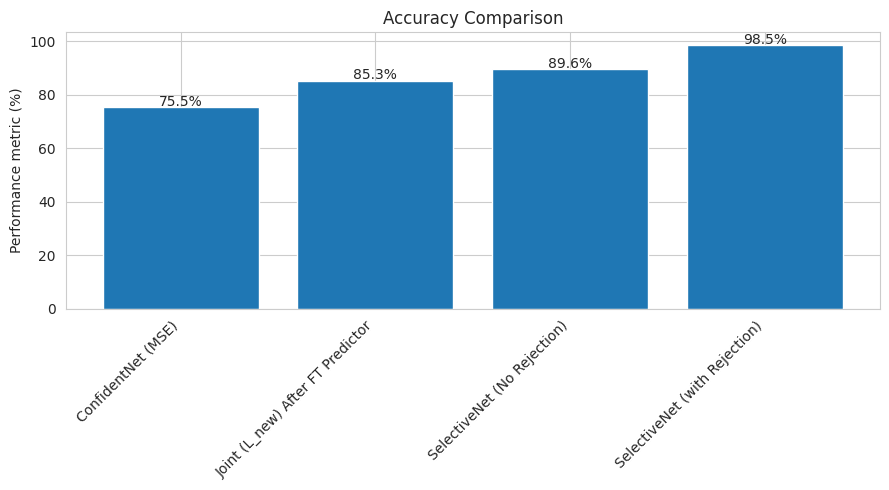

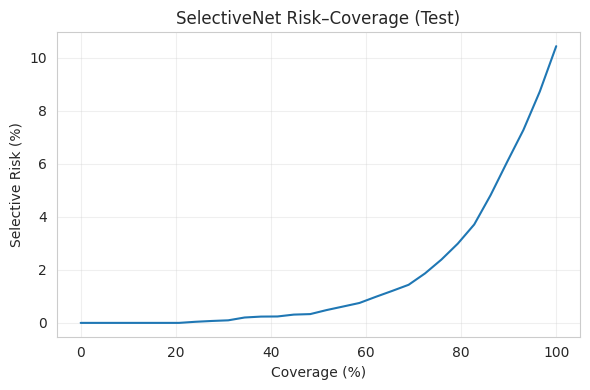

In [21]:
# ============================
# PLOTS & COMPARISONS
# ============================

# ---- (A) Confidence distributions for ConfidentNet & L_new
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
plt.title("Confidence Distributions — ConfidentNet (MSE) vs Joint (L_new)")
sns.histplot(mse_confidences[np.array(mse_correctness)==1], color='skyblue', label='Correct (MSE)', kde=True, stat='density', alpha=0.6, bins=50)
sns.histplot(mse_confidences[np.array(mse_correctness)==0], color='salmon',  label='Incorrect (MSE)', kde=True, stat='density', alpha=0.6, bins=50)
sns.histplot(lnew_confidences[np.array(lnew_correctness)==1], color='blue',   label='Correct (L_new)', kde=True, stat='density', alpha=0.35, bins=50)
sns.histplot(lnew_confidences[np.array(lnew_correctness)==0], color='red',    label='Incorrect (L_new)', kde=True, stat='density', alpha=0.35, bins=50)
plt.xlabel("Predicted Confidence"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

# ---- (B) Build a comparison table (using the re-calculated/loaded results)
# For ConfidentNet/L_new you already compute: accuracy, auroc, auprc, mean_conf_*.
# For SelectiveNet we’ll record: coverage, acc_on_accepted.

# Need to re-calculate initial and finetuned predictor accuracy for L_new for the table
# Load the initial predictor model (used for ConfidentNet and Joint training before fine-tuning)
initial_predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
initial_predictor.load_state_dict(torch.load(base_paths['predictor'], map_location=DEVICE))
initial_predictor_accuracy = evaluate_predictor_accuracy(initial_predictor, test_loader, DEVICE)

# Load the fine-tuned Joint model (L_new) and extract the predictor part
finetuned_path_lnew_for_predictor_eval = Path(f"models/finetuned_model_L_new.pth")
combined_model_state_dict_lnew_for_predictor_eval = torch.load(finetuned_path_lnew_for_predictor_eval, map_location=DEVICE)
finetuned_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
predictor_state_dict_lnew_for_predictor_eval = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_lnew_for_predictor_eval.items() if 'predictor_model.' in k}
finetuned_predictor_lnew.load_state_dict(predictor_state_dict_lnew_for_predictor_eval)
finetuned_predictor_lnew_accuracy = evaluate_predictor_accuracy(finetuned_predictor_lnew, test_loader, DEVICE)

# Need to re-calculate SelectiveNet (No Rejection) metrics for the table
selective_model_path_for_full_eval = Path("models/finetuned_selectivenet_selective_objective.pth")
ckpt_sel_for_full_eval = torch.load(selective_model_path_for_full_eval, map_location=DEVICE)
sel_model_for_full_eval = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
sel_model_for_full_eval.load_state_dict(ckpt_sel_for_full_eval["state_dict"]); sel_model_for_full_eval.eval().to(DEVICE)
selective_net_predictor_backbone_for_full_eval = sel_model_for_full_eval.backbone

all_predictions_full_eval = []
all_labels_full_eval = []
all_probs_full_eval = []

selective_net_predictor_backbone_for_full_eval.to(DEVICE).eval()

with torch.no_grad():
    for inputs, labels in test_loader_val:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = selective_net_predictor_backbone_for_full_eval(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted_classes = torch.max(outputs, 1)

        all_predictions_full_eval.extend(predicted_classes.cpu().numpy())
        all_labels_full_eval.extend(labels.cpu().numpy())
        all_probs_full_eval.extend(probs.max(dim=1).values.cpu().numpy())

is_correct_list_sel_full_eval = np.array(all_predictions_full_eval) == np.array(all_labels_full_eval)
predicted_confidence_list_sel_full_eval = np.array(all_probs_full_eval)
failure_labels_sel_full_eval = 1 - is_correct_list_sel_full_eval
failure_scores_sel_full_eval = 1 - predicted_confidence_list_sel_full_eval

accuracy_sel_full = np.mean(is_correct_list_sel_full_eval) * 100
auroc_sel_full = roc_auc_score(failure_labels_sel_full_eval, failure_scores_sel_full_eval)
auprc_sel_full = average_precision_score(failure_labels_sel_full_eval, failure_scores_sel_full_eval)



rows_all = []
rows_all.append({"method":"ConfidentNet (MSE)", "accuracy":mse_results["accuracy"], "auroc":mse_results["auroc"], "auprc":mse_results["auprc"],
             "coverage":np.nan, "acc_on_accepted":np.nan})
#rows_all.append({"method":"Joint (L_new) Before Finetuning", "accuracy":initial_predictor_accuracy, "auroc":np.nan, "auprc":np.nan,
#             "coverage":np.nan, "acc_on_accepted":np.nan})
#rows_all.append({"method":"Joint (L_new) After Finetuning Predictor", "accuracy":finetuned_predictor_lnew_accuracy, "auroc":np.nan, "auprc":np.nan,
#             "coverage":np.nan, "acc_on_accepted":np.nan})
rows_all.append({"method":"Joint (L_new) After Finetuning", "accuracy":finetuned_predictor_lnew_accuracy, "auroc":lnew_results["auroc"], "auprc":lnew_results["auprc"],
             "coverage":np.nan, "acc_on_accepted":np.nan})
rows_all.append({"method":"SelectiveNet (No Rejection)", "accuracy":accuracy_sel_full, "auroc":auroc_sel_full, "auprc":auprc_sel_full,
             "coverage":100.0, "acc_on_accepted":accuracy_sel_full})
rows_all.append({"method":"SelectiveNet (with Rejection)", "accuracy":np.nan, "auroc":np.nan, "auprc":np.nan,
             "coverage":sel_metrics["coverage"]*100, "acc_on_accepted":sel_metrics["acc_on_accepted"]*100})


comparison_df_final = pd.DataFrame(rows_all).set_index("method")


print("\n--- 📊 Updated Final Metrics Comparison (mixed) ---")
display(comparison_df_final)


# ---- (C) Small summary bar chart
plt.figure(figsize=(9,5))
ax = plt.gca()
# Update labels and values for the bar chart based on the refined table
left = ["ConfidentNet (MSE)", "Joint (L_new) After FT Predictor", "SelectiveNet (No Rejection)", "SelectiveNet (with Rejection)"]
vals = [mse_results["accuracy"], finetuned_predictor_lnew_accuracy, accuracy_sel_full, sel_metrics["acc_on_accepted"]*100]
plt.bar(left, vals)
plt.ylabel("Performance metric (%)")
plt.title("Accuracy Comparison")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
for i,v in enumerate(vals):
    plt.text(i, v+0.5, f"{v:.1f}%", ha='center')
plt.tight_layout(); plt.show()


# ---- (D) risk–coverage curve for SelectiveNet
try:
    # Provide inline version using the trained SelectiveNet saved by run_experiment:
    ckpt = torch.load(Path("models/finetuned_selectivenet_selective_objective.pth"), map_location=DEVICE)
    # rebuild selective model as before
    sel_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
    sel_model.load_state_dict(ckpt["state_dict"]); sel_model.eval().to(DEVICE)

    # collect g and correctness on test set
    all_g, all_correct = [], []
    with torch.no_grad():
        for x, y in test_loader_val:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits_f, _, g_logit = sel_model(x)
            pred = logits_f.argmax(dim=1)
            correct = (pred == y).detach().cpu().numpy().astype(np.float32)
            g = torch.sigmoid(g_logit).detach().cpu().numpy()
            all_g.append(g); all_correct.append(correct)
    g = np.concatenate(all_g); correct = np.concatenate(all_correct)

    taus = np.quantile(g, np.linspace(0, 1, 30))
    covs, risks = [], []
    for tau in taus:
        accept = g >= tau
        cov = accept.mean()
        if accept.sum() > 0:
            risk = 1.0 - (correct[accept].mean())  # error on accepted
        else:
            risk = np.nan
        covs.append(cov); risks.append(risk)
    plt.figure(figsize=(6,4))
    plt.plot(np.array(covs)*100, np.array(risks)*100)
    plt.xlabel("Coverage (%)"); plt.ylabel("Selective Risk (%)")
    plt.title("SelectiveNet Risk–Coverage (Test)")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

except Exception as e:
    print(f"Error generating risk-coverage curve: {e}")

In [24]:
# Load the trained SelectiveNet model and threshold
selective_model_path = Path("models/finetuned_selectivenet_selective_objective.pth")
ckpt_sel = torch.load(selective_model_path, map_location=DEVICE)
selective_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
selective_model.load_state_dict(ckpt_sel["state_dict"])
selective_model.eval().to(DEVICE)

# Use the test_loader_val for evaluation
_, _, test_loader_val = get_cifar10_loaders_with_val(batch_size=BATCH_SIZE)

# Collect g scores and correctness labels from the test set
all_g, all_correct = [], []
with torch.no_grad():
    for x, y in test_loader_val:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits_f, _, g_logit = selective_model(x)
        pred = logits_f.argmax(dim=1)
        correct = (pred == y).detach().cpu().numpy().astype(np.float32)
        g = torch.sigmoid(g_logit).detach().cpu().numpy()
        all_g.append(g)
        all_correct.append(correct)

g_all = np.concatenate(all_g)
correct_all = np.concatenate(all_correct)

# Define the target coverage levels
target_coverages = [0.80, 0.85, 0.90, 0.95, 1.00] # 100% coverage is no rejection

# Calculate the threshold (tau) for each target coverage
# Tau is the (1 - target_coverage) quantile of the g scores
taus = [np.quantile(g_all, 1.0 - tc) for tc in target_coverages]

# Calculate empirical risk and actual coverage for each threshold
results = []
for i, tc in enumerate(target_coverages):
    tau = taus[i]
    accept = g_all >= tau
    actual_coverage = accept.mean() * 100
    if accept.sum() > 0:
        empirical_risk = (1.0 - correct_all[accept].mean()) * 100 # Error rate on accepted
        accuracy_on_accepted = 100 - empirical_risk
    else:
        empirical_risk = np.nan
        accuracy_on_accepted = np.nan # Cannot calculate accuracy if no samples are accepted

    results.append({
        "Target Coverage (%)": tc * 100,
        "Threshold (tau)": tau,
        "Actual Coverage (%)": actual_coverage,
        "Empirical Risk (%)": empirical_risk,
        "Accuracy on Accepted (%)": accuracy_on_accepted
    })

# Create a pandas DataFrame and display the table
coverage_risk_df = pd.DataFrame(results)
print("\n--- SelectiveNet Risk-Coverage Table ---")
display(coverage_risk_df)


--- SelectiveNet Risk-Coverage Table ---


,Target Coverage (%),Threshold (tau),Actual Coverage (%),Empirical Risk (%),Accuracy on Accepted (%)
0,80.0,0.083830,80.0,3.162497,96.837502
1,85.0,0.028828,85.0,4.388237,95.611763
2,90.0,0.011038,90.0,6.133336,93.866661
3,95.0,0.005371,95.0,8.021050,91.978951
4,100.0,0.001332,100.0,10.430002,89.570000


#3. Test and evaluations

In [9]:
import requests
from PIL import Image
import io

# List of 25 CIFAR-10 sample image URLs
image_urls = [
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat5.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer1.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer2.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer3.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png",
    "https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer5.png"
]

downloaded_images = []
for url in image_urls:
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    downloaded_images.append(image)

print(f"{len(downloaded_images)} images have been downloaded successfully.")

25 images have been downloaded successfully.


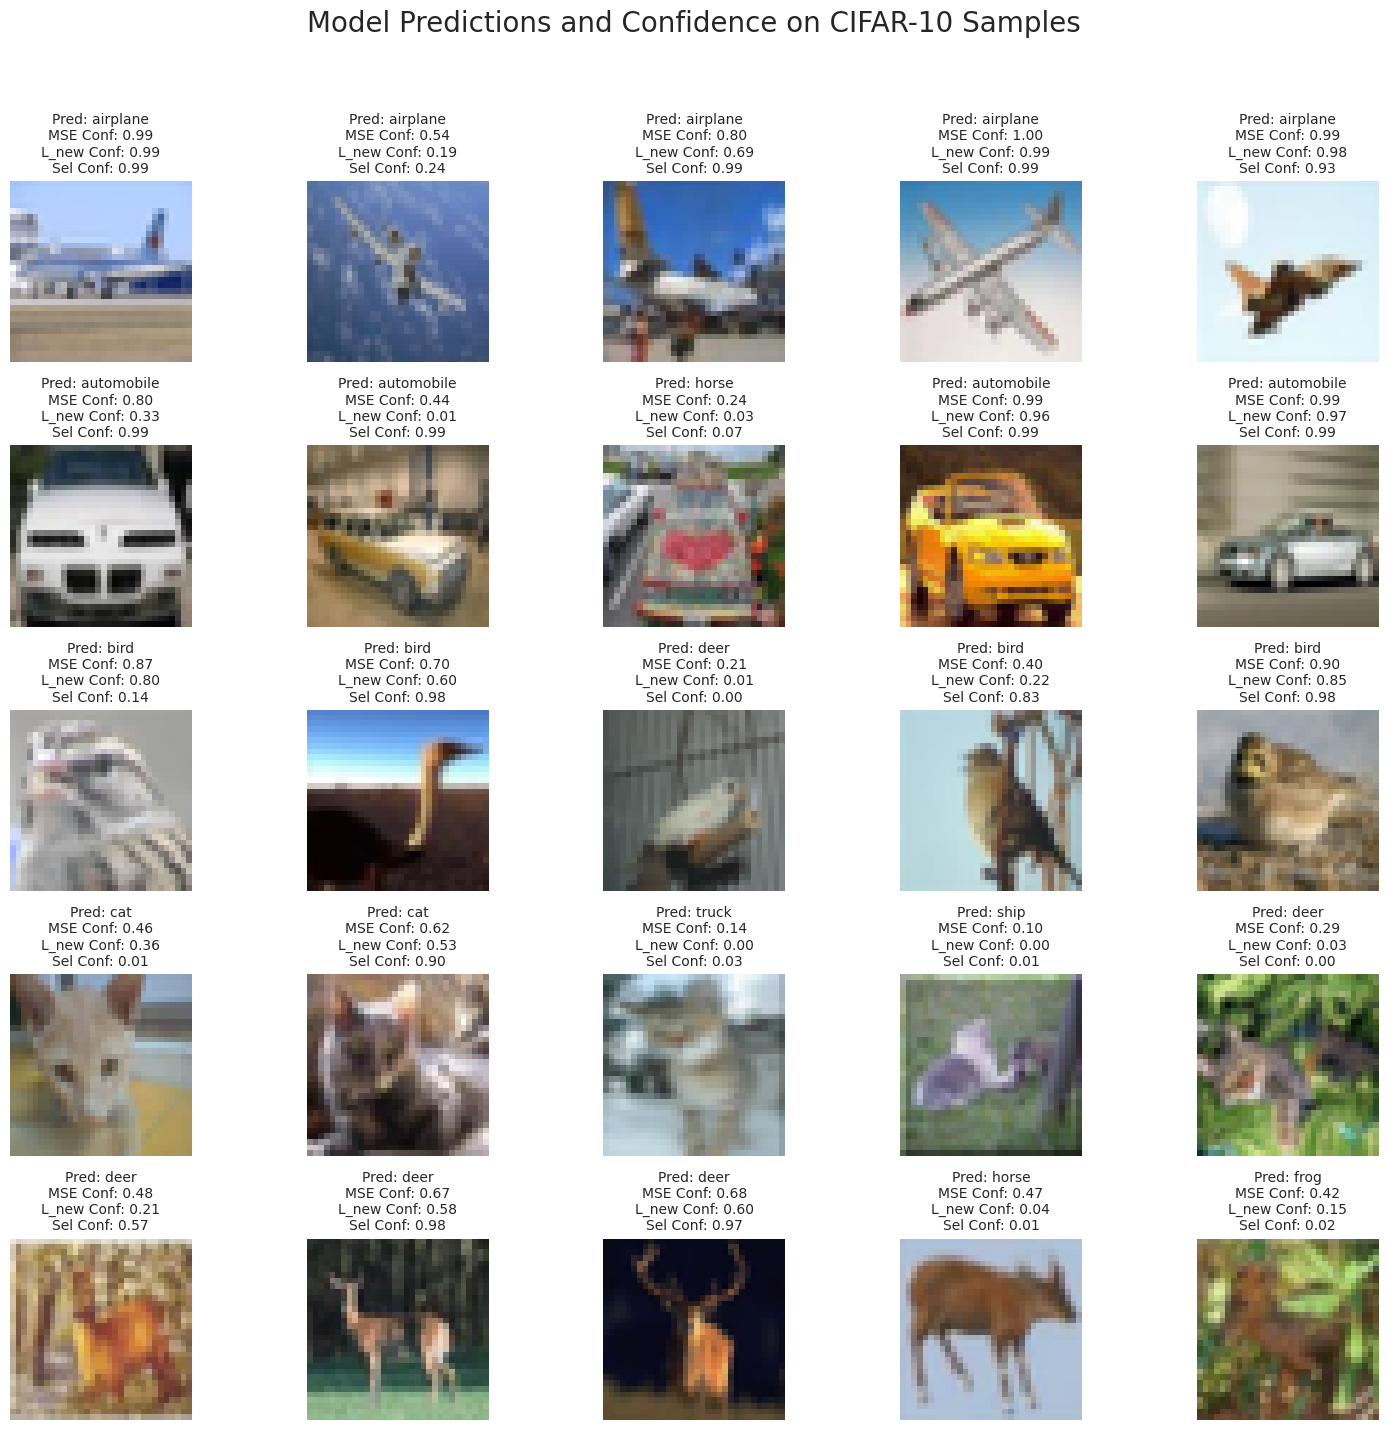

In [10]:
# Define the same transformations as used for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the fine-tuned models
# MSE Model
finetuned_path_mse = Path(f"models/finetuned_model_MSE.pth")
final_predictor_mse = VGGStylePredictor(num_classes=NUM_CLASSES)
final_predictor_mse.load_state_dict(torch.load(predictor_path))
final_predictor_mse.eval().to(DEVICE)
final_conviction_net_mse = MLPConvictionNet(input_dim=final_predictor_mse.feature_dim)
combined_model_state_dict_mse = torch.load(finetuned_path_mse)
conviction_net_state_dict_mse = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_mse.items() if 'conviction_network.' in k}
final_conviction_net_mse.load_state_dict(conviction_net_state_dict_mse)
final_conviction_net_mse.eval().to(DEVICE)

# L_new Model
finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
final_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
final_predictor_lnew.load_state_dict(torch.load(predictor_path))
final_predictor_lnew.eval().to(DEVICE)
final_conviction_net_lnew = MLPConvictionNet(input_dim=final_predictor_lnew.feature_dim)
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew)
conviction_net_state_dict_lnew = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'conviction_network.' in k}
final_conviction_net_lnew.load_state_dict(conviction_net_state_dict_lnew)
final_conviction_net_lnew.eval().to(DEVICE)

# SelectiveNet Model
selective_model_path = Path("models/finetuned_selectivenet_selective_objective.pth")
ckpt_sel = torch.load(selective_model_path, map_location=DEVICE)
selective_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
selective_model.load_state_dict(ckpt_sel["state_dict"])
selective_model.eval().to(DEVICE)


def predict_image_confidence(image, predictor, conviction_net, transform, device):
    """Predicts the class and confidence for a single image using ConfidentNet/Joint approach."""
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = predictor.get_features(image_tensor)
        outputs = predictor.classifier(features)
        _, predicted_class = torch.max(outputs.data, 1)
        confidence = conviction_net(features).squeeze().item()
    return cifar10_class_names[predicted_class.item()], confidence

def predict_selective_confidence(image, selective_model, transform, device):
    """Predicts the class and confidence for a single image using SelectiveNet approach."""
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits_f, _, g_logit = selective_model(image_tensor)
        probs = F.softmax(logits_f, dim=1)
        _, predicted_class = torch.max(probs.data, 1)
        confidence = torch.sigmoid(g_logit).item()
    return cifar10_class_names[predicted_class.item()], confidence


# Create the 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Model Predictions and Confidence on CIFAR-10 Samples', fontsize=20)

for i, image in enumerate(downloaded_images):
    ax = axes[i // 5, i % 5]
    ax.imshow(image)

    # Get predictions and confidence from all models
    pred_class_mse, conf_mse = predict_image_confidence(image, final_predictor_mse, final_conviction_net_mse, test_transform, DEVICE)
    pred_class_lnew, conf_lnew = predict_image_confidence(image, final_predictor_lnew, final_conviction_net_lnew, test_transform, DEVICE)
    pred_class_sel, conf_sel = predict_selective_confidence(image, selective_model, test_transform, DEVICE)


    ax.set_title(f"Pred: {pred_class_mse}\n"
                 f"MSE Conf: {conf_mse:.2f}\n"
                 f"L_new Conf: {conf_lnew:.2f}\n"
                 f"Sel Conf: {conf_sel:.2f}", # Added SelectiveNet confidence
                 fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Error downloading https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2: 404 Client Error: Not Found for url: https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2
9 images have been downloaded successfully.


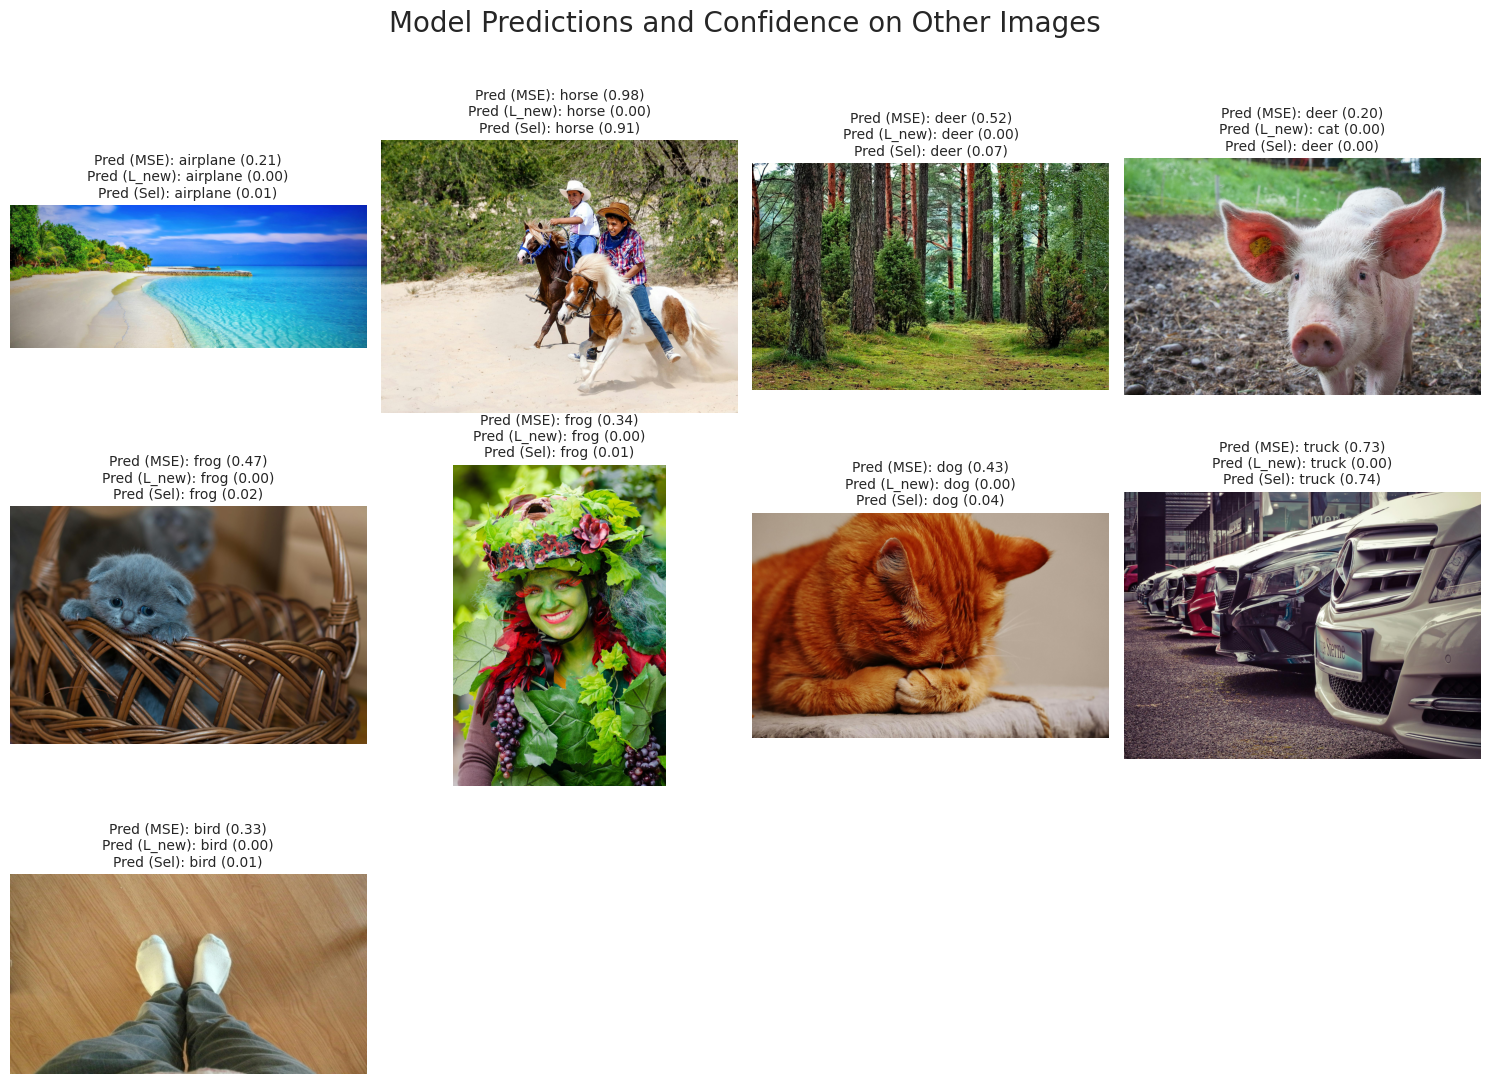

In [11]:
import requests
from PIL import Image
import io

# Define URLs for sample images not from CIFAR-10
# These are diverse images to see how the model generalizes
other_image_urls = [
    "https://images.pexels.com/photos/248797/pexels-photo-248797.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Beach
    "https://images.pexels.com/photos/132068/pexels-photo-132068.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Mountain
    "https://images.pexels.com/photos/302804/pexels-photo-302804.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Coffee
    "https://images.pexels.com/photos/110820/pexels-photo-110820.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Dog
    "https://images.pexels.com/photos/127027/pexels-photo-127027.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Cat
    "https://images.pexels.com/photos/145934/pexels-photo-145934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Bird
    "https://images.pexels.com/photos/209037/pexels-photo-209037.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Car
    "https://images.pexels.com/photos/164634/pexels-photo-164634.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Truck
    "https://images.pexels.com/photos/1000365/pexels-photo-1000365.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Ship
    "https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Airplane
]

downloaded_other_images = []
for url in other_image_urls:
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        image = Image.open(io.BytesIO(response.content)).convert("RGB") # Ensure image is in RGB
        downloaded_other_images.append(image)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"Error processing image from {url}: {e}")


print(f"{len(downloaded_other_images)} images have been downloaded successfully.")

# Define the same transformations as used for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the fine-tuned models (assuming they are saved from the previous step)
finetuned_path_mse = Path(f"models/finetuned_model_MSE.pth")
final_predictor_mse = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_mse = torch.load(finetuned_path_mse, map_location=DEVICE)
predictor_state_dict_mse = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_mse.items() if 'predictor_model.' in k}
final_predictor_mse.load_state_dict(predictor_state_dict_mse)
final_predictor_mse.eval().to(DEVICE)

final_conviction_net_mse = MLPConvictionNet(input_dim=final_predictor_mse.feature_dim)
conviction_net_state_dict_mse = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_mse.items() if 'conviction_network.' in k}
final_conviction_net_mse.load_state_dict(conviction_net_state_dict_mse)
final_conviction_net_mse.eval().to(DEVICE)


finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
final_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew, map_location=DEVICE)
predictor_state_dict_lnew = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'predictor_model.' in k}
final_predictor_lnew.load_state_dict(predictor_state_dict_lnew)
final_predictor_lnew.eval().to(DEVICE)

final_conviction_net_lnew = MLPConvictionNet(input_dim=final_predictor_lnew.feature_dim)
conviction_net_state_dict_lnew = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'conviction_network.' in k}
final_conviction_net_lnew.load_state_dict(conviction_net_state_dict_lnew)
final_conviction_net_lnew.eval().to(DEVICE)

# SelectiveNet Model
selective_model_path = Path("models/finetuned_selectivenet_selective_objective.pth")
ckpt_sel = torch.load(selective_model_path, map_location=DEVICE)
selective_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
selective_model.load_state_dict(ckpt_sel["state_dict"])
selective_model.eval().to(DEVICE)


# Function to predict class and confidence for a single image
def predict_image_confidence(image, predictor, conviction_net, transform, device):
    """Predicts the class and confidence for a single image."""
    # Resize the image to 32x32 to match CIFAR-10 input size
    image = image.resize((32, 32))
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = predictor.get_features(image_tensor)
        outputs = predictor.classifier(features)
        _, predicted_class = torch.max(outputs.data, 1)
        confidence = conviction_net(features).squeeze().item()
    return cifar10_class_names[predicted_class.item()], confidence

# Function to predict class and confidence for a single image (SelectiveNet)
def predict_selective_confidence(image, selective_model, transform, device):
    """Predicts the class and confidence for a single image using SelectiveNet approach."""
    # Resize the image to 32x32 to match CIFAR-10 input size
    image = image.resize((32, 32))
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits_f, _, g_logit = selective_model(image_tensor)
        probs = F.softmax(logits_f, dim=1)
        _, predicted_class = torch.max(probs.data, 1)
        confidence = torch.sigmoid(g_logit).item()
    return cifar10_class_names[predicted_class.item()], confidence


# Determine grid size (e.g., 3x4 for 10 images)
n_images = len(downloaded_other_images)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Model Predictions and Confidence on Other Images', fontsize=20)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, image in enumerate(downloaded_other_images):
    ax = axes[i]
    ax.imshow(image)

    # Get predictions from both models
    pred_class_mse, conf_mse = predict_image_confidence(image, final_predictor_mse, final_conviction_net_mse, test_transform, DEVICE)
    pred_class_lnew, conf_lnew = predict_image_confidence(image, final_predictor_lnew, final_conviction_net_lnew, test_transform, DEVICE)
    pred_class_sel, conf_sel = predict_selective_confidence(image, selective_model, test_transform, DEVICE)


    ax.set_title(f"Pred (MSE): {pred_class_mse} ({conf_mse:.2f})\n"
                 f"Pred (L_new): {pred_class_lnew} ({conf_lnew:.2f})\n"
                 f"Pred (Sel): {pred_class_sel} ({conf_sel:.2f})", # Added SelectiveNet confidence
                 fontsize=10)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Error downloading https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2: 404 Client Error: Not Found for url: https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2
24 images have been downloaded and resized successfully.


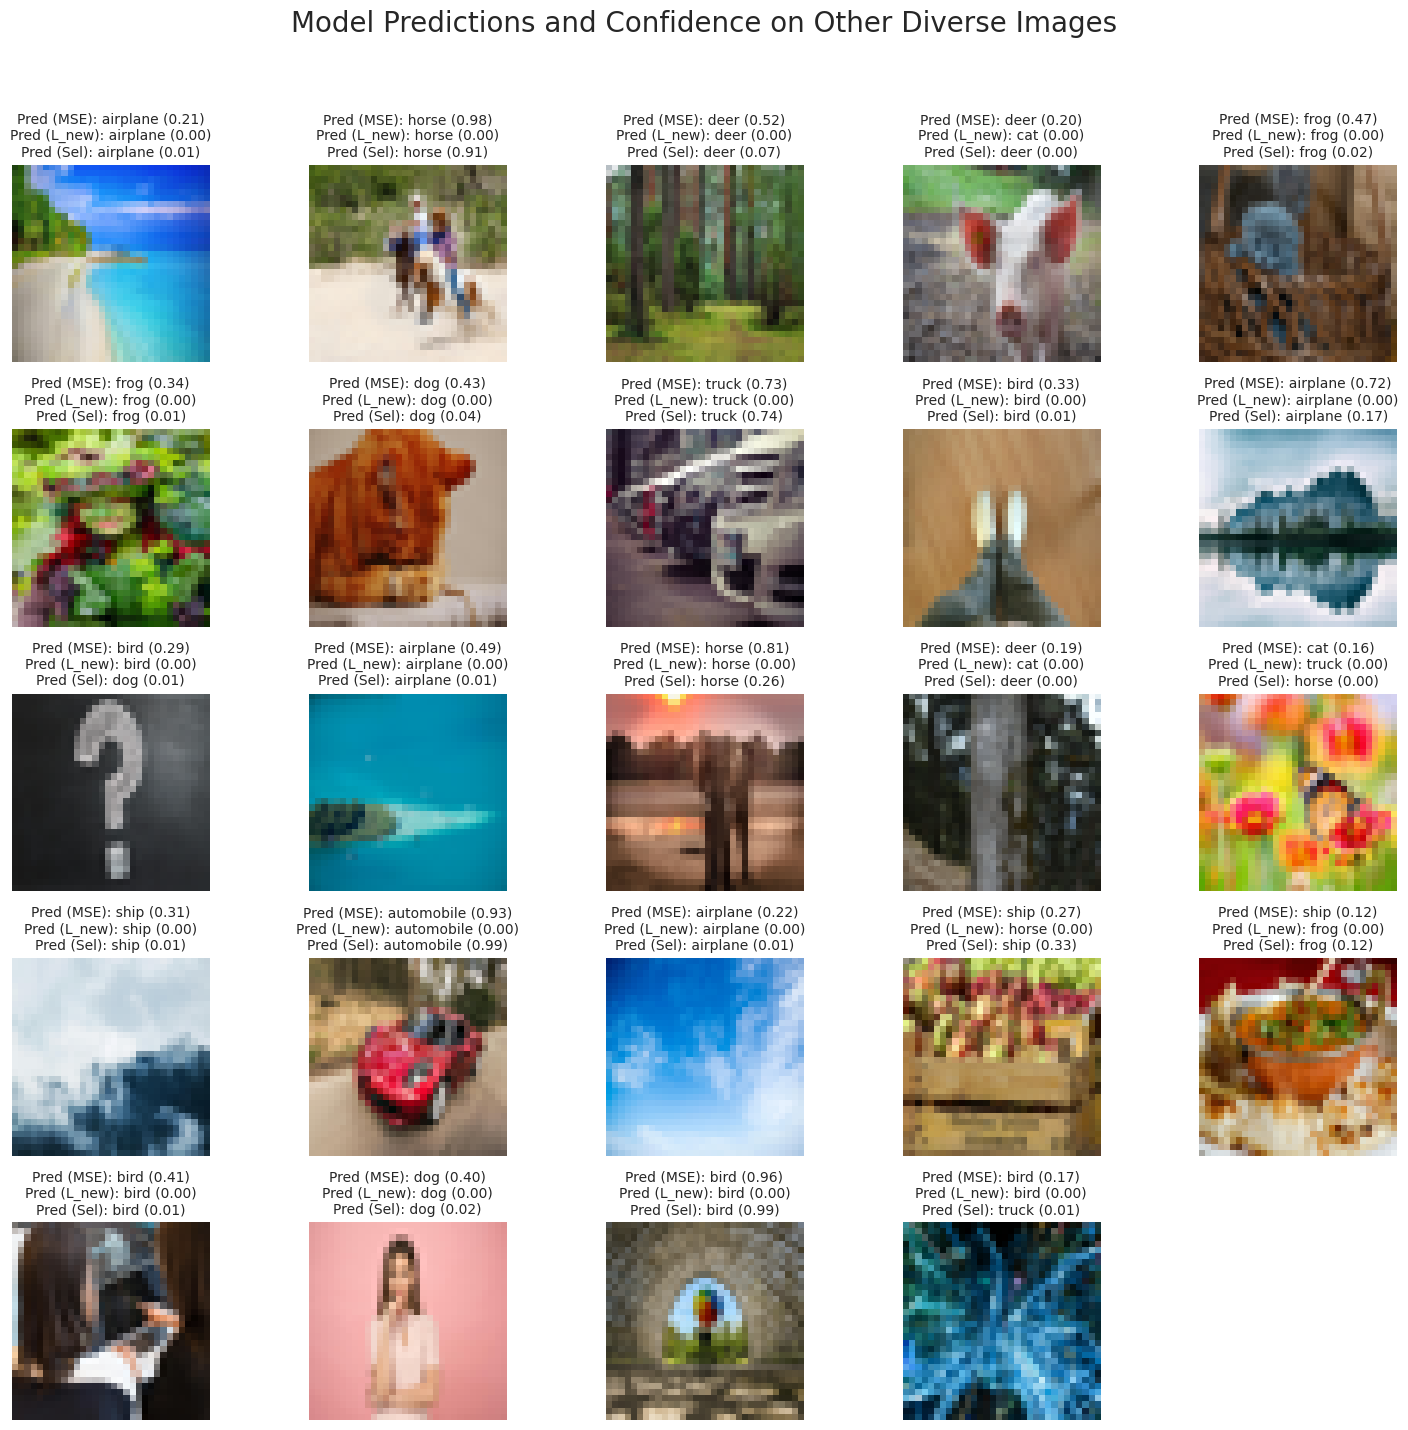

In [12]:
import requests
from PIL import Image
import io

# Define URLs for a new set of 25 diverse images (not from CIFAR-10)
# These are diverse images to see how the model generalizes
# Let's use a mix of image categories.
other_image_urls_25 = [
    "https://images.pexels.com/photos/248797/pexels-photo-248797.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Beach
    "https://images.pexels.com/photos/132068/pexels-photo-132068.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Mountain
    "https://images.pexels.com/photos/302804/pexels-photo-302804.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Coffee
    "https://images.pexels.com/photos/110820/pexels-photo-110820.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Dog
    "https://images.pexels.com/photos/127027/pexels-photo-127027.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Cat
    "https://images.pexels.com/photos/145934/pexels-photo-145934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Bird
    "https://images.pexels.com/photos/209037/pexels-photo-209037.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Car
    "https://images.pexels.com/photos/164634/pexels-photo-164634.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Truck
    "https://images.pexels.com/photos/1000365/pexels-photo-1000365.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Ship
    "https://images.pexels.com/photos/1564771/pexels-photo-1564771.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Airplane
    "https://images.pexels.com/photos/459225/pexels-photo-459225.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Forest
    "https://images.pexels.com/photos/356079/pexels-photo-356079.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Horse
    "https://images.pexels.com/photos/1528411/pexels-photo-1528411.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Deer
    "https://images.pexels.com/photos/1054655/pexels-photo-1054655.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Frog
    "https://images.pexels.com/photos/1334918/pexels-photo-1334918.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Flower
    "https://images.pexels.com/photos/462118/pexels-photo-462118.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Library
    "https://images.pexels.com/photos/167699/pexels-photo-167699.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Building
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Cityscape
    "https://images.pexels.com/photos/912110/pexels-photo-912110.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Person
    "https://images.pexels.com/photos/265362/pexels-photo-265362.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Food
    "https://images.pexels.com/photos/2474661/pexels-photo-2474661.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Abstract
    "https://images.pexels.com/photos/1181263/pexels-photo-1181263.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Laptop
    "https://images.pexels.com/photos/1036623/pexels-photo-1036623.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Music
    "https://images.pexels.com/photos/355874/pexels-photo-355874.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2", # Space
    "https://images.pexels.com/photos/373543/pexels-photo-373543.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2"  # Art
]


downloaded_other_images_25 = []
for url in other_image_urls_25:
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        image = Image.open(io.BytesIO(response.content)).convert("RGB") # Ensure image is in RGB
        # Resize the image to 32x32 to match CIFAR-10 input size
        image = image.resize((32, 32))
        downloaded_other_images_25.append(image)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except Exception as e:
        print(f"Error processing image from {url}: {e}")


print(f"{len(downloaded_other_images_25)} images have been downloaded and resized successfully.")

# Define the same transformations as used for the test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the fine-tuned models (assuming they are saved from the previous step)
finetuned_path_mse = Path(f"models/finetuned_model_MSE.pth")
final_predictor_mse = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_mse = torch.load(finetuned_path_mse, map_location=DEVICE)
predictor_state_dict_mse = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_mse.items() if 'predictor_model.' in k}
final_predictor_mse.load_state_dict(predictor_state_dict_mse)
final_predictor_mse.eval().to(DEVICE)

final_conviction_net_mse = MLPConvictionNet(input_dim=final_predictor_mse.feature_dim)
conviction_net_state_dict_mse = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_mse.items() if 'conviction_network.' in k}
final_conviction_net_mse.load_state_dict(conviction_net_state_dict_mse)
final_conviction_net_mse.eval().to(DEVICE)


finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
final_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
# Load the state dict for the predictor part from the saved combined model state dict
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew, map_location=DEVICE)
predictor_state_dict_lnew = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'predictor_model.' in k}
final_predictor_lnew.load_state_dict(predictor_state_dict_lnew)
final_predictor_lnew.eval().to(DEVICE)

final_conviction_net_lnew = MLPConvictionNet(input_dim=final_predictor_lnew.feature_dim)
conviction_net_state_dict_lnew = {k.replace('conviction_network.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'conviction_network.' in k}
final_conviction_net_lnew.load_state_dict(conviction_net_state_dict_lnew)
final_conviction_net_lnew.eval().to(DEVICE)

# SelectiveNet Model
selective_model_path = Path("models/finetuned_selectivenet_selective_objective.pth")
ckpt_sel = torch.load(selective_model_path, map_location=DEVICE)
selective_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
selective_model.load_state_dict(ckpt_sel["state_dict"])
selective_model.eval().to(DEVICE)


# Function to predict class and confidence for a single image (ConfidentNet/Joint)
def predict_image_confidence(image, predictor, conviction_net, transform, device):
    """Predicts the class and confidence for a single image."""
    # The image is already resized to 32x32 during download
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = predictor.get_features(image_tensor)
        outputs = predictor.classifier(features)
        _, predicted_class = torch.max(outputs.data, 1)
        confidence = conviction_net(features).squeeze().item()
    return cifar10_class_names[predicted_class.item()], confidence

# Function to predict class and confidence for a single image (SelectiveNet)
def predict_selective_confidence(image, selective_model, transform, device):
    """Predicts the class and confidence for a single image using SelectiveNet approach."""
    # The image is already resized to 32x32 during download
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits_f, _, g_logit = selective_model(image_tensor)
        probs = F.softmax(logits_f, dim=1)
        _, predicted_class = torch.max(probs.data, 1)
        confidence = torch.sigmoid(g_logit).item()
    return cifar10_class_names[predicted_class.item()], confidence


# Create the 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Model Predictions and Confidence on Other Diverse Images', fontsize=20)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, image in enumerate(downloaded_other_images_25):
    ax = axes[i]
    ax.imshow(image)

    # Get predictions from both models
    pred_class_mse, conf_mse = predict_image_confidence(image, final_predictor_mse, final_conviction_net_mse, test_transform, DEVICE)
    pred_class_lnew, conf_lnew = predict_image_confidence(image, final_predictor_lnew, final_conviction_net_lnew, test_transform, DEVICE)
    pred_class_sel, conf_sel = predict_selective_confidence(image, selective_model, test_transform, DEVICE)


    ax.set_title(f"Pred (MSE): {pred_class_mse} ({conf_mse:.2f})\n"
                 f"Pred (L_new): {pred_class_lnew} ({conf_lnew:.2f})\n"
                 f"Pred (Sel): {pred_class_sel} ({conf_sel:.2f})", # Added SelectiveNet confidence
                 fontsize=10)
    ax.axis('off')

# Hide any unused subplots (shouldn't be any with 25 images in a 5x5 grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
#                     accuracy     auroc     auprc  mean_conf_correct  mean_conf_incorrect
# Fine-Tuned (MSE)       85.17  0.902578  0.590752           0.868726             0.479288
# Fine-Tuned (L_new)     85.17  0.899625  0.582576           0.788549             0.253872

In [18]:

# Load the initial predictor model (used for ConfidentNet and Joint training before fine-tuning)
initial_predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
initial_predictor.load_state_dict(torch.load(base_paths['predictor'], map_location=DEVICE))

# Load the fine-tuned Joint model (L_new) and extract the predictor part
finetuned_path_lnew = Path(f"models/finetuned_model_L_new.pth")
combined_model_state_dict_lnew = torch.load(finetuned_path_lnew, map_location=DEVICE)

finetuned_predictor_lnew = VGGStylePredictor(num_classes=NUM_CLASSES)
predictor_state_dict_lnew = {k.replace('predictor_model.', ''): v for k, v in combined_model_state_dict_lnew.items() if 'predictor_model.' in k}
finetuned_predictor_lnew.load_state_dict(predictor_state_dict_lnew)


# Evaluate accuracy on the test set
initial_predictor_accuracy = evaluate_predictor_accuracy(initial_predictor, test_loader, DEVICE)
finetuned_predictor_lnew_accuracy = evaluate_predictor_accuracy(finetuned_predictor_lnew, test_loader, DEVICE)

print(f"Accuracy of the initial predictor (used in ConfidentNet and before Joint fine-tuning): {initial_predictor_accuracy:.2f}%")
print(f"Accuracy of the predictor after Joint fine-tuning (L_new): {finetuned_predictor_lnew_accuracy:.2f}%")

Accuracy of the initial predictor (used in ConfidentNet and before Joint fine-tuning): 75.47%
Accuracy of the predictor after Joint fine-tuning (L_new): 85.27%


In [19]:
# Load the trained SelectiveNet model
selective_model_path = Path("models/finetuned_selectivenet_selective_objective.pth")
ckpt = torch.load(selective_model_path, map_location=DEVICE)

# Build the SelectiveNet model and load the state dict
selective_model = build_selectivenet(VGGStylePredictor, num_classes=NUM_CLASSES)
selective_model.load_state_dict(ckpt["state_dict"])
selective_model.eval().to(DEVICE)

# Extract the entire predictor backbone from the SelectiveNet model
# This includes feature extraction and the main classifier head
selective_net_predictor_backbone = selective_model.backbone

# Use the test_loader (or test_loader_val, which was used for SelectiveNet evaluation)
# We'll use test_loader_val for consistency with the selective evaluation part
_, _, test_loader_val = get_cifar10_loaders_with_val(batch_size=BATCH_SIZE)


# Evaluate the accuracy of the predictor head on the full test set
selective_net_full_accuracy = evaluate_predictor_accuracy(
    predictor_model=selective_net_predictor_backbone, # Pass the entire backbone
    data_loader=test_loader_val,
    device=DEVICE
)

print(f"Accuracy of SelectiveNet's predictor head on the full test set (no rejection): {selective_net_full_accuracy:.2f}%")

Accuracy of SelectiveNet's predictor head on the full test set (no rejection): 89.57%


# Additional test (using sampling approximation)
Implement and evaluate a sampling approximation for the denominator of the $L_{new}$ loss function during joint training.

In [25]:
class L_new_SamplingLoss(nn.Module):
    """
    Implementation of the L_new loss for joint training using Sampling approximation.
    L_new = sum(conviction * predictor_loss) / sum(conviction) (approximated by sampling)
    """
    def __init__(self, train_dataset, sampling_percentage=0.1, sampling_batch_size=None):
        super().__init__()
        # Use CrossEntropyLoss with no reduction to get per-sample loss
        self.predictor_loss_fn = nn.CrossEntropyLoss(reduction='none')
        self.train_dataset = train_dataset
        self.sampling_percentage = sampling_percentage
        self.sampling_batch_size = sampling_batch_size

        if sampling_batch_size is None and sampling_percentage is None:
            raise ValueError("Either sampling_percentage or sampling_batch_size must be provided.")
        if sampling_batch_size is not None and sampling_percentage is not None:
             print("Warning: Both sampling_percentage and sampling_batch_size are provided. Using sampling_batch_size.")
             self.sampling_percentage = None # Prioritize batch size

    def forward(self, predictor_outputs, labels, conviction_scores, joint_model):
        # 1. Calculate the predictor's per-sample loss for the current batch
        per_sample_predictor_loss = self.predictor_loss_fn(predictor_outputs, labels)

        # 2. Calculate the numerator: conviction-weighted predictor loss for the current batch
        numerator = torch.sum(conviction_scores.squeeze() * per_sample_predictor_loss)

        # 3. Sample a subset of the training dataset to approximate the denominator sum
        dataset_size = len(self.train_dataset)
        if self.sampling_batch_size is not None:
            num_samples = min(self.sampling_batch_size, dataset_size)
        else:
            num_samples = int(dataset_size * self.sampling_percentage)

        # Ensure num_samples is at least 1
        num_samples = max(1, num_samples)

        # Randomly sample indices
        sampled_indices = torch.randperm(dataset_size)[:num_samples]

        # Create a DataLoader for the sampled subset
        sampled_dataset = torch.utils.data.Subset(self.train_dataset, sampled_indices)
        # Use a large batch size for the sampling loader to process faster, but keep shuffle=False
        # as we just need the sum of convictions, order doesn't matter.
        # Also, ensure we don't use more workers than available or needed for a small batch.
        # Using batch_size=num_samples processes all sampled data in one batch.
        sampled_loader = torch.utils.data.DataLoader(
            sampled_dataset,
            batch_size=num_samples,
            shuffle=False,
            num_workers=0 # Set to 0 to avoid multiprocessing issues within forward pass
        )

        # Calculate the sum of conviction scores for the sampled subset
        # This part needs the joint_model to get features and conviction scores
        # We need to ensure the joint_model is in evaluation mode and on the correct device
        original_mode = joint_model.training
        joint_model.eval()
        original_device = next(joint_model.parameters()).device

        sum_of_sampled_convictions = 0.0
        with torch.no_grad():
            for sampled_inputs, _ in sampled_loader:
                 sampled_inputs = sampled_inputs.to(original_device)
                 # Use the joint model's internal predictor to get features
                 features = joint_model.predictor_model.get_features(sampled_inputs)
                 # Use the joint model's internal conviction network
                 sampled_conviction_scores = joint_model.conviction_network(features).squeeze()
                 sum_of_sampled_convictions += torch.sum(sampled_conviction_scores).item()


        # Restore original model state
        joint_model.train(original_mode)


        # 4. Calculate the final loss using the sampled denominator
        # Add a small epsilon to the denominator to prevent division by zero
        denominator = sum_of_sampled_convictions + 1e-8
        final_loss = numerator / denominator

        return final_loss

## Train the joint model with sampling approximation

In [26]:
# path for the sampling approximation model
finetuned_lnew_sampling_path = MODELS_DIR / "finetuned_model_L_new_sampling.pth"

# Check if the model file already exists
if not finetuned_lnew_sampling_path.exists():
    print(f"\n{'='*30}\n💥 STARTING EXPERIMENT: L_new (Sampling) 💥\n{'='*30}")
    print(f"--- Stage 3 (Fine-Tuning): Using L_new Sampling loss ---")

    # Initialize and load base models
    predictor = VGGStylePredictor(num_classes=NUM_CLASSES)
    predictor.load_state_dict(torch.load(base_paths['predictor'], map_location=DEVICE))

    conviction_net = MLPConvictionNet(input_dim=predictor.feature_dim)
    conviction_net.load_state_dict(torch.load(base_paths['conviction'], map_location=DEVICE))

    # Initialize the joint model and move to device
    joint_model = JointTrainingModel(predictor, conviction_net).to(DEVICE)

    # Instantiate the L_new_SamplingLoss criterion
    # We need the full trainset, which is available from get_cifar10_loaders_with_val
    # Let's use a fixed sampling batch size for simplicity, e.g., 512
    train_dataset_full = get_cifar10_loaders_with_val(batch_size=BATCH_SIZE)[0].dataset # Get the dataset from the train loader
    criterion_sampling = L_new_SamplingLoss(train_dataset=train_dataset_full, sampling_batch_size=512).to(DEVICE)

    # Define the optimizer
    optimizer_sampling = optim.Adam(joint_model.parameters(), lr=LR_FINETUNE)

    # --- Fine-Tuning Loop (L_new Sampling) ---
    for epoch in range(EPOCHS_FINETUNE):
        joint_model.train()
        running_loss_sampling = 0.0
        for i, (inputs, labels) in enumerate(train_loader): # Use the original train_loader
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer_sampling.zero_grad()

            # Forward pass through the joint model
            predictor_outputs, conviction_scores = joint_model(inputs)

            # Calculate the L_new loss using the sampling approximation
            loss_sampling = criterion_sampling(predictor_outputs, labels, conviction_scores, joint_model)

            # Backward pass and optimization
            loss_sampling.backward()
            optimizer_sampling.step()
            running_loss_sampling += loss_sampling.item()

            if i % 100 == 99:
                print(f'Epoch [{epoch + 1}/{EPOCHS_FINETUNE}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss_sampling / 100:.4f}')
                running_loss_sampling = 0.0

    # Save the fine-tuned model
    torch.save(joint_model.state_dict(), finetuned_lnew_sampling_path)
    print(f"✅ Fine-tuned model (L_new Sampling) saved to {finetuned_lnew_sampling_path}\n")

else:
    print(f"--- Fine-tuning L_new Sampling: Found existing model at {finetuned_lnew_sampling_path}, skipping training. ---")


💥 STARTING EXPERIMENT: L_new (Sampling) 💥
--- Stage 3 (Fine-Tuning): Using L_new Sampling loss ---
Epoch [1/20], Step [100/391], Loss: 0.0678
Epoch [1/20], Step [200/391], Loss: 0.0527
Epoch [1/20], Step [300/391], Loss: 0.0318
Epoch [2/20], Step [100/391], Loss: 0.0122
Epoch [2/20], Step [200/391], Loss: 0.0079
Epoch [2/20], Step [300/391], Loss: 0.0057
Epoch [3/20], Step [100/391], Loss: 0.0039
Epoch [3/20], Step [200/391], Loss: 0.0041
Epoch [3/20], Step [300/391], Loss: 0.0031
Epoch [4/20], Step [100/391], Loss: 0.0020
Epoch [4/20], Step [200/391], Loss: 0.0018
Epoch [4/20], Step [300/391], Loss: 0.0017
Epoch [5/20], Step [100/391], Loss: 0.0012
Epoch [5/20], Step [200/391], Loss: 0.0007
Epoch [5/20], Step [300/391], Loss: 0.0007
Epoch [6/20], Step [100/391], Loss: 0.0013
Epoch [6/20], Step [200/391], Loss: 0.0008
Epoch [6/20], Step [300/391], Loss: 0.0006
Epoch [7/20], Step [100/391], Loss: 0.0008
Epoch [7/20], Step [200/391], Loss: 0.0010
Epoch [7/20], Step [300/391], Loss: 0.00

## Evaluate the model (sampling) [Results to be checked]


In [27]:
# path for the sampling approximation model
finetuned_lnew_sampling_path = MODELS_DIR / "finetuned_model_L_new_sampling.pth"

# Load the fine-tuned Joint model (L_new Sampling)
joint_model_lnew_sampling = JointTrainingModel(
    VGGStylePredictor(num_classes=NUM_CLASSES),
    MLPConvictionNet(input_dim=VGGStylePredictor().feature_dim)
).to(DEVICE)
joint_model_lnew_sampling.load_state_dict(torch.load(finetuned_lnew_sampling_path, map_location=DEVICE))

# Extract predictor and conviction net from the joint model
predictor_lnew_sampling = joint_model_lnew_sampling.predictor_model
conviction_net_lnew_sampling = joint_model_lnew_sampling.conviction_network

# Evaluate using the loaded fine-tuned model
lnew_sampling_results, lnew_sampling_confidences, lnew_sampling_correctness = evaluate_conviction_system(
    predictor=predictor_lnew_sampling,
    conviction_model=conviction_net_lnew_sampling,
    test_loader=test_loader, # Use the original test_loader
    device=DEVICE
)

--- Evaluating Conviction System ---
Base Predictor Accuracy: 85.42%
AUROC for Failure Prediction: 0.7124
AUPRC for Failure Prediction: 0.2292
Mean Confidence (Correct): 0.0023
Mean Confidence (Incorrect): 0.0000
